In [1]:
import sys
sys.path.append('..')

import csv
import os
import torch
import librosa
import numpy as np
import librosa.display
from pypesq import pesq
from pystoi import stoi
from fastdtw import fastdtw
import matplotlib.pyplot as plt
from IPython.display import Audio
import matplotlib.gridspec as gridspec
from scipy.spatial.distance import euclidean
from dataset.HiFiGanDataset import HiFiGanDataset
from hparams.HiFiGanHParams import HiFiGanHParams as hps
from inference_handlers.HiFiGanInferenceHandler import HiFiGanInferenceHandler
from inference_handlers.Tacotron2InferenceHandler import Tacotron2InferenceHandler

In [2]:
tacotron2_ro_d_ckpt_path = "/train_path/working_models/tacotron2_ro_d"
tacotron2_ro_di_ckpt_path = "/train_path/working_models/tacotron2_ro"
hifigan_ft_ckpt_path = "/train_path/working_models/hifigan"
hifigan_ckpt_path = "/train_path/working_models/hifigan_ft_ro"
cleaners_ro = ["basic_cleaners"]
cleaners_ro_di = ["transliteration_cleaners"]

metadata_path = "/train_path/Mara/metadata.csv"
base_wavs_path = "/train_path/Mara/wavs/"

sr = 22050

In [3]:
with open(metadata_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="|")
        data = list(reader)[:50]

pairs = [
        {
            'path': f'{base_wavs_path}{p[0]}.wav',
            'text': p[1]
        }
        for p in data
    ]

In [4]:
tacotron2_ro = Tacotron2InferenceHandler(
    tacotron2_ro_d_ckpt_path,
    use_cuda=True,
    use_ro=True
)

tacotron2_ro_di = Tacotron2InferenceHandler(
    tacotron2_ro_di_ckpt_path,
    use_cuda=True,
)

hifigan = HiFiGanInferenceHandler(
    hifigan_ckpt_path,
    use_cuda=True
)

hifigan_ft = HiFiGanInferenceHandler(
    hifigan_ft_ckpt_path,
    use_cuda=True
)


def infer_ro(text):
    # Tacotron2 synthesis
    tacotron2_mel, alignments = tacotron2_ro.infer_e2e(
        text,
        cleaners=cleaners_ro,
    )

    # HiFi-GAN synthesis
    wav, sr = hifigan.infer(tacotron2_mel)
    
    return wav


def infer_ro_di(text):
    # Tacotron2 synthesis
    tacotron2_mel, alignments = tacotron2_ro_di.infer_e2e(
        text,
        cleaners=cleaners_ro_di,
    )

    # HiFi-GAN synthesis
    wav, sr = hifigan.infer(tacotron2_mel)
    
    return wav


def infer_ro_hf(text):
    # Tacotron2 synthesis
    tacotron2_mel, alignments = tacotron2_ro.infer_e2e(
        text,
        cleaners=cleaners_ro,
    )

    # HiFi-GAN synthesis
    wav, sr = hifigan_ft.infer(tacotron2_mel)
    
    return wav


def infer_ro_di_hf(text):
    # Tacotron2 synthesis
    tacotron2_mel, alignments = tacotron2_ro_di.infer_e2e(
        text,
        cleaners=cleaners_ro_di,
    )

    # HiFi-GAN synthesis
    wav, sr = hifigan_ft.infer(tacotron2_mel)
    
    return wav


def read_sentence(path):
    wav, _ = HiFiGanDataset._load_wav(path)
    return wav

Removing weight norm...
Removing weight norm...


In [5]:
def compute_mcd(ref_audio, synth_audio, sr=22050, n_mfcc=13):
    ref_audio = ref_audio.astype('float32')
    synth_audio = synth_audio.astype('float32')
    
    min_len = min(len(ref_audio), len(synth_audio))
    ref_audio = ref_audio[:min_len]
    synth_audio = synth_audio[:min_len]

    # Compute MFCCs for both signals
    mfcc_ref = librosa.feature.mfcc(ref_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_synth = librosa.feature.mfcc(synth_audio, sr=sr, n_mfcc=n_mfcc)
    
    mcd = np.mean(np.sqrt(2 * np.sum((mfcc_ref - mfcc_synth)**2, axis=0)))
    return mcd


def compute_mcd_dtw(ref_audio, synth_audio, sr=22050, n_mfcc=13):
    ref_audio = ref_audio.astype('float32')
    synth_audio = synth_audio.astype('float32')
    
    # Compute MFCCs for both signals
    mfcc_ref = librosa.feature.mfcc(ref_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_synth = librosa.feature.mfcc(synth_audio, sr=sr, n_mfcc=n_mfcc)
    
    # Transpose MFCC matrices for DTW alignment (time-major format)
    mfcc_ref = mfcc_ref.T
    mfcc_synth = mfcc_synth.T
    
    # Compute DTW distance between MFCC sequences
    _, d = fastdtw(mfcc_ref, mfcc_synth, dist=euclidean)
    
    # Compute MCD-DTW as the square root of the mean of DTW distances
    mcd_dtw = np.sqrt(np.mean(d))
    
    return mcd_dtw


def compute_stoi_score(ref, syn, sr):

    # Ensure the length is the same
    min_len = min(len(ref), len(syn))
    ref = ref[:min_len]
    syn = syn[:min_len]

    score = stoi(ref, syn, sr, extended=False)
    return score


def compute_pesq_score(ref, syn, sr):
    target_sr = 8000
    ref = librosa.resample(ref.astype('float32'), sr, target_sr)
    syn = librosa.resample(syn.astype('float32'), sr, target_sr)

    # Ensure the length is the same
    min_len = min(len(ref), len(syn))
    ref = ref[:min_len]
    syn = syn[:min_len]

    score = pesq(ref, syn, target_sr)
    return score


def compute_pitch(y, sr):  
    # Use Harmonic/Percussive Source Separation (HPSS)
    harmonic, percussive = librosa.effects.hpss(y.astype('float32'))

    # Extract pitch using librosa's piptrack
    pitches, magnitudes = librosa.core.piptrack(y=harmonic, sr=sr, fmin=librosa.note_to_hz('E2'), fmax=librosa.note_to_hz('C5'))

    # Extract the pitch values from the piptrack output
    pitch = np.zeros(pitches.shape[1])
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch[t] = pitches[index, t] if magnitudes[index, t] > 0 else np.nan

    return pitch

In [6]:
stats = []

for pair in pairs:
    ro_wav = infer_ro(pair['text'])
    ro_di_wav = infer_ro_di(pair['text'])
    ro_hf_wav = infer_ro_hf(pair['text'])
    ro_di_hf_wav = infer_ro_di_hf(pair['text'])
    real_wav = read_sentence(pair['path'])
    
    pitch_real = compute_pitch(real_wav, sr)
    pitch_syn_ro = compute_pitch(ro_wav, sr)
    pitch_syn_ro_di = compute_pitch(ro_di_wav, sr)
    pitch_syn_ro_hf = compute_pitch(ro_hf_wav, sr)
    pitch_syn_ro_di_hf = compute_pitch(ro_di_hf_wav, sr)

    mcd_ro = compute_mcd(real_wav, ro_wav)
    mcd_ro_di = compute_mcd(real_wav, ro_di_wav)
    mcd_ro_hf = compute_mcd(real_wav, ro_hf_wav)
    mcd_ro_di_hf = compute_mcd(real_wav, ro_di_hf_wav)
    
    mcd_dtw_ro = compute_mcd_dtw(real_wav, ro_wav)
    mcd_dtw_ro_di = compute_mcd_dtw(real_wav, ro_di_wav)
    mcd_dtw_ro_hf = compute_mcd_dtw(real_wav, ro_hf_wav)
    mcd_dtw_ro_di_hf = compute_mcd_dtw(real_wav, ro_di_hf_wav)
    
    stoi_ro = compute_stoi_score(real_wav, ro_wav, sr)
    stoi_ro_di = compute_stoi_score(real_wav, ro_di_wav, sr)
    stoi_ro_hf = compute_stoi_score(real_wav, ro_hf_wav, sr)
    stoi_ro_di_hf = compute_stoi_score(real_wav, ro_di_hf_wav, sr)
    
    pesq_ro = compute_pesq_score(real_wav, ro_wav, sr)
    pesq_ro_di = compute_pesq_score(real_wav, ro_di_wav, sr)
    pesq_ro_hf = compute_pesq_score(real_wav, ro_hf_wav, sr)
    pesq_ro_di_hf = compute_pesq_score(real_wav, ro_di_hf_wav, sr)

    
    stats.append({
        'pitch_real': pitch_real,
        'pitch_syn_ro': pitch_syn_ro,
        'pitch_syn_ro_di': pitch_syn_ro_di,
        'pitch_syn_ro_hf': pitch_syn_ro_hf,
        'pitch_syn_ro_di_hf': pitch_syn_ro_di_hf,
        'mcd_ro': mcd_ro,
        'mcd_ro_di': mcd_ro_di,
        'mcd_ro_hf': mcd_ro_hf,
        'mcd_ro_di_hf': mcd_ro_di_hf,
        'mcd_dtw_ro': mcd_dtw_ro,
        'mcd_dtw_ro_di': mcd_dtw_ro_di,
        'mcd_dtw_ro_hf': mcd_dtw_ro_hf,
        'mcd_dtw_ro_di_hf': mcd_dtw_ro_di_hf,
        'stoi_ro': stoi_ro,
        'stoi_ro_di': stoi_ro_di,
        'stoi_ro_hf': stoi_ro_hf,
        'stoi_ro_di_hf': stoi_ro_di_hf,
        'pesq_ro': pesq_ro,
        'pesq_ro_di': pesq_ro_di,
        'pesq_ro_hf': pesq_ro_hf,
        'pesq_ro_di_hf': pesq_ro_di_hf
    })

Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.


In [7]:
# Helper function to extract and flatten pitch values
def extract_and_flatten_pitch(stats, key):
    return np.concatenate([d[key][~np.isnan(d[key])] for d in stats])

# Extract and flatten pitch values
pitch_real_values = extract_and_flatten_pitch(stats, 'pitch_real')
pitch_syn_ro_values = extract_and_flatten_pitch(stats, 'pitch_syn_ro')
pitch_syn_ro_di_values = extract_and_flatten_pitch(stats, 'pitch_syn_ro_di')
pitch_syn_ro_hf_values = extract_and_flatten_pitch(stats, 'pitch_syn_ro_hf')
pitch_syn_ro_di_hf_values = extract_and_flatten_pitch(stats, 'pitch_syn_ro_di_hf')

# Extract metric values
mcd_ro_values = np.array([d['mcd_ro'] for d in stats])
mcd_ro_di_values = np.array([d['mcd_ro_di'] for d in stats])
mcd_ro_hf_values = np.array([d['mcd_ro_hf'] for d in stats])
mcd_ro_di_hf_values = np.array([d['mcd_ro_di_hf'] for d in stats])

mcd_dtw_ro_values = np.array([d['mcd_dtw_ro'] for d in stats])
mcd_dtw_ro_di_values = np.array([d['mcd_dtw_ro_di'] for d in stats])
mcd_dtw_ro_hf_values = np.array([d['mcd_dtw_ro_hf'] for d in stats])
mcd_dtw_ro_di_hf_values = np.array([d['mcd_dtw_ro_di_hf'] for d in stats])

stoi_ro_values = np.array([d['stoi_ro'] for d in stats])
stoi_ro_di_values = np.array([d['stoi_ro_di'] for d in stats])
stoi_ro_hf_values = np.array([d['stoi_ro_hf'] for d in stats])
stoi_ro_di_hf_values = np.array([d['stoi_ro_di_hf'] for d in stats])

pesq_ro_values = np.array([d['pesq_ro'] for d in stats])
pesq_ro_di_values = np.array([d['pesq_ro_di'] for d in stats])
pesq_ro_hf_values = np.array([d['pesq_ro_hf'] for d in stats])
pesq_ro_di_hf_values = np.array([d['pesq_ro_di_hf'] for d in stats])

# Compute averages and standard deviations using NumPy
average_pitch_real = np.nanmean(pitch_real_values)
std_dev_pitch_real = np.nanstd(pitch_real_values)

average_pitch_syn_ro = np.nanmean(pitch_syn_ro_values)
std_dev_pitch_syn_ro = np.nanstd(pitch_syn_ro_values)

average_pitch_syn_ro_di = np.nanmean(pitch_syn_ro_di_values)
std_dev_pitch_syn_ro_di = np.nanstd(pitch_syn_ro_di_values)

average_pitch_syn_ro_hf = np.nanmean(pitch_syn_ro_hf_values)
std_dev_pitch_syn_ro_hf = np.nanstd(pitch_syn_ro_hf_values)

average_pitch_syn_ro_di_hf = np.nanmean(pitch_syn_ro_di_hf_values)
std_dev_pitch_syn_ro_di_hf = np.nanstd(pitch_syn_ro_di_hf_values)

average_mcd_ro = np.mean(mcd_ro_values)
std_dev_mcd_ro = np.std(mcd_ro_values)

average_mcd_ro_di = np.mean(mcd_ro_di_values)
std_dev_mcd_ro_di = np.std(mcd_ro_di_values)

average_mcd_ro_hf = np.mean(mcd_ro_hf_values)
std_dev_mcd_ro_hf = np.std(mcd_ro_hf_values)

average_mcd_ro_di_hf = np.mean(mcd_ro_di_hf_values)
std_dev_mcd_ro_di_hf = np.std(mcd_ro_di_hf_values)

average_mcd_dtw_ro = np.mean(mcd_dtw_ro_values)
std_dev_mcd_dtw_ro = np.std(mcd_dtw_ro_values)

average_mcd_dtw_ro_di = np.mean(mcd_dtw_ro_di_values)
std_dev_mcd_dtw_ro_di = np.std(mcd_dtw_ro_di_values)

average_mcd_dtw_ro_hf = np.mean(mcd_dtw_ro_hf_values)
std_dev_mcd_dtw_ro_hf = np.std(mcd_dtw_ro_hf_values)

average_mcd_dtw_ro_di_hf = np.mean(mcd_dtw_ro_di_hf_values)
std_dev_mcd_dtw_ro_di_hf = np.std(mcd_dtw_ro_di_hf_values)

average_stoi_ro = np.mean(stoi_ro_values)
std_dev_stoi_ro = np.std(stoi_ro_values)

average_stoi_ro_di = np.mean(stoi_ro_di_values)
std_dev_stoi_ro_di = np.std(stoi_ro_di_values)

average_stoi_ro_hf = np.mean(stoi_ro_hf_values)
std_dev_stoi_ro_hf = np.std(stoi_ro_hf_values)

average_stoi_ro_di_hf = np.mean(stoi_ro_di_hf_values)
std_dev_stoi_ro_di_hf = np.std(stoi_ro_di_hf_values)

average_pesq_ro = np.mean(pesq_ro_values)
std_dev_pesq_ro = np.std(pesq_ro_values)

average_pesq_ro_di = np.mean(pesq_ro_di_values)
std_dev_pesq_ro_di = np.std(pesq_ro_di_values)

average_pesq_ro_hf = np.mean(pesq_ro_hf_values)
std_dev_pesq_ro_hf = np.std(pesq_ro_hf_values)

average_pesq_ro_di_hf = np.mean(pesq_ro_di_hf_values)
std_dev_pesq_ro_di_hf = np.std(pesq_ro_di_hf_values)

# Print or use the results
print("Average and Standard Deviation Results:")
print(f"Pitch Real - Average: {average_pitch_real}, Std Dev: {std_dev_pitch_real}")
print(f"Pitch Syn RO - Average: {average_pitch_syn_ro}, Std Dev: {std_dev_pitch_syn_ro}")
print(f"Pitch Syn RO DI - Average: {average_pitch_syn_ro_di}, Std Dev: {std_dev_pitch_syn_ro_di}")
print(f"Pitch Syn RO HF - Average: {average_pitch_syn_ro_hf}, Std Dev: {std_dev_pitch_syn_ro_hf}")
print(f"Pitch Syn RO DI HF - Average: {average_pitch_syn_ro_di_hf}, Std Dev: {std_dev_pitch_syn_ro_di_hf}")
print(f"MCD RO - Average: {average_mcd_ro}, Std Dev: {std_dev_mcd_ro}")
print(f"MCD RO DI - Average: {average_mcd_ro_di}, Std Dev: {std_dev_mcd_ro_di}")
print(f"MCD RO HF - Average: {average_mcd_ro_hf}, Std Dev: {std_dev_mcd_ro_hf}")
print(f"MCD RO DI HF - Average: {average_mcd_ro_di_hf}, Std Dev: {std_dev_mcd_ro_di_hf}")
print(f"MCD DTW RO - Average: {average_mcd_dtw_ro}, Std Dev: {std_dev_mcd_dtw_ro}")
print(f"MCD DTW RO DI - Average: {average_mcd_dtw_ro_di}, Std Dev: {std_dev_mcd_dtw_ro_di}")
print(f"MCD DTW RO HF - Average: {average_mcd_dtw_ro_hf}, Std Dev: {std_dev_mcd_dtw_ro_hf}")
print(f"MCD DTW RO DI HF - Average: {average_mcd_dtw_ro_di_hf}, Std Dev: {std_dev_mcd_dtw_ro_di_hf}")
print(f"STOI RO - Average: {average_stoi_ro}, Std Dev: {std_dev_stoi_ro}")
print(f"STOI RO DI - Average: {average_stoi_ro_di}, Std Dev: {std_dev_stoi_ro_di}")
print(f"STOI RO HF - Average: {average_stoi_ro_hf}, Std Dev: {std_dev_stoi_ro_hf}")
print(f"STOI RO DI HF - Average: {average_stoi_ro_di_hf}, Std Dev: {std_dev_stoi_ro_di_hf}")
print(f"PESQ RO - Average: {average_pesq_ro}, Std Dev: {std_dev_pesq_ro}")
print(f"PESQ RO DI - Average: {average_pesq_ro_di}, Std Dev: {std_dev_pesq_ro_di}")
print(f"PESQ RO HF - Average: {average_pesq_ro_hf}, Std Dev: {std_dev_pesq_ro_hf}")
print(f"PESQ RO DI HF - Average: {average_pesq_ro_di_hf}, Std Dev: {std_dev_pesq_ro_di_hf}")

Average and Standard Deviation Results:
Pitch Real - Average: 225.63763594694473, Std Dev: 83.08043731905298
Pitch Syn RO - Average: 207.88922343684263, Std Dev: 72.94586110344699
Pitch Syn RO DI - Average: 208.04275375448677, Std Dev: 74.19060594386606
Pitch Syn RO HF - Average: 227.53673462402267, Std Dev: 87.35550415402894
Pitch Syn RO DI HF - Average: 226.02492904474147, Std Dev: 87.47452387191156
MCD RO - Average: 228.03754465988794, Std Dev: 35.538994570110965
MCD RO DI - Average: 221.2387956272416, Std Dev: 50.99209077022129
MCD RO HF - Average: 240.28612342518306, Std Dev: 39.78042940754586
MCD RO DI HF - Average: 239.76833859896007, Std Dev: 45.75207554601514
MCD DTW RO - Average: 11.139018044020407, Std Dev: 1.863413426466446
MCD DTW RO DI - Average: 10.983025399441741, Std Dev: 1.8071306123573567
MCD DTW RO HF - Average: 11.117513900721024, Std Dev: 1.8716042909934676
MCD DTW RO DI HF - Average: 10.94503501154956, Std Dev: 1.7911473884890505
STOI RO - Average: 0.206286835698

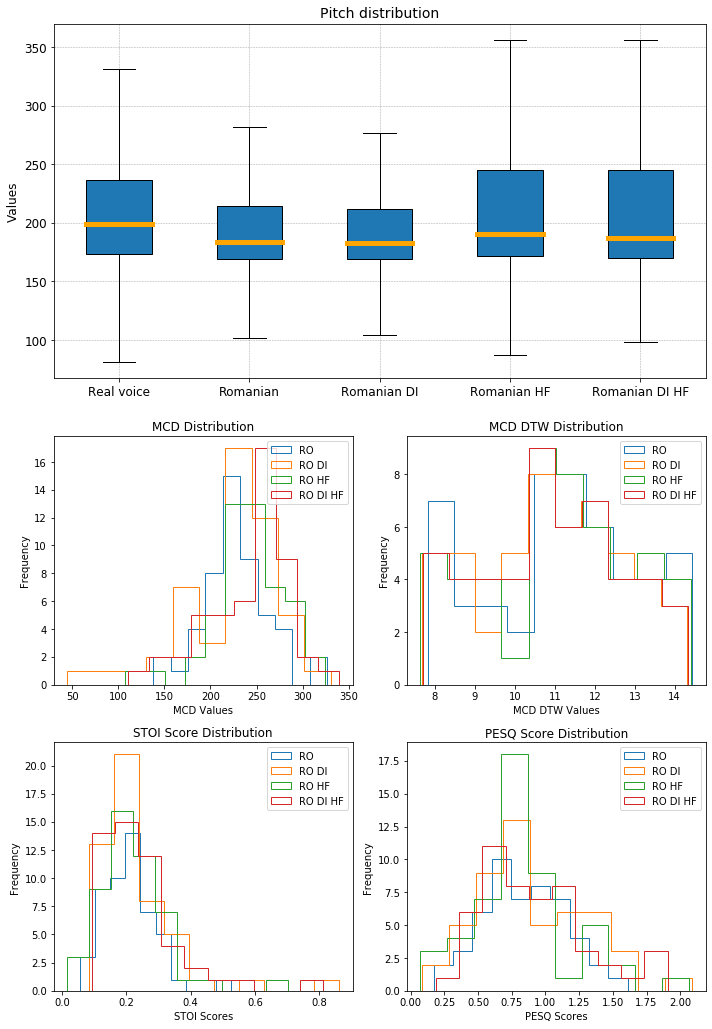

In [18]:
# Create a figure
fig = plt.figure(figsize=(10, 15))

gs = gridspec.GridSpec(3, 2, height_ratios=[1, 0.7, 0.7])

# Plot Pitch Real and Pitch Syn (wider plot)
ax1 = fig.add_subplot(gs[0, :])
box = ax1.boxplot(
    [pitch_real_values, pitch_syn_ro_values, pitch_syn_ro_di_values, pitch_syn_ro_hf_values, pitch_syn_ro_di_hf_values],
    labels=['Real voice', 'Romanian', 'Romanian DI', 'Romanian HF', 'Romanian DI HF'],
    patch_artist=True,
    showfliers=False
)
ax1.set_title('Pitch distribution', fontsize=14)
ax1.set_ylabel('Values', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
for median in box['medians']:
    median.set(linewidth=5, color='orange')

# Plot MCD
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(mcd_ro_values, bins=10, histtype='step', label='RO')
ax2.hist(mcd_ro_di_values, bins=10, histtype='step', label='RO DI')
ax2.hist(mcd_ro_hf_values, bins=10, histtype='step', label='RO HF')
ax2.hist(mcd_ro_di_hf_values, bins=10, histtype='step', label='RO DI HF')
ax2.set_title('MCD Distribution')
ax2.set_xlabel('MCD Values')
ax2.set_ylabel('Frequency')
ax2.legend(loc='upper right')

# Plot MCD DTW
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(mcd_dtw_ro_values, bins=10, histtype='step', label='RO')
ax3.hist(mcd_dtw_ro_di_values, bins=10, histtype='step', label='RO DI')
ax3.hist(mcd_dtw_ro_hf_values, bins=10, histtype='step', label='RO HF')
ax3.hist(mcd_dtw_ro_di_hf_values, bins=10, histtype='step', label='RO DI HF')
ax3.set_title('MCD DTW Distribution')
ax3.set_xlabel('MCD DTW Values')
ax3.set_ylabel('Frequency')
ax3.legend(loc='upper right')

# Plot STOI Score
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(stoi_ro_values, bins=10, histtype='step', label='RO')
ax4.hist(stoi_ro_di_values, bins=10, histtype='step', label='RO DI')
ax4.hist(stoi_ro_hf_values, bins=10, histtype='step', label='RO HF')
ax4.hist(stoi_ro_di_hf_values, bins=10, histtype='step', label='RO DI HF')
ax4.set_title('STOI Score Distribution')
ax4.set_xlabel('STOI Scores')
ax4.set_ylabel('Frequency')
ax4.legend(loc='upper right')

# Plot PESQ Score
ax5 = fig.add_subplot(gs[2, 1])
ax5.hist(pesq_ro_values, bins=10, histtype='step', label='RO')
ax5.hist(pesq_ro_di_values, bins=10, histtype='step', label='RO DI')
ax5.hist(pesq_ro_hf_values, bins=10, histtype='step', label='RO HF')
ax5.hist(pesq_ro_di_hf_values, bins=10, histtype='step', label='RO DI HF')
ax5.set_title('PESQ Score Distribution')
ax5.set_xlabel('PESQ Scores')
ax5.set_ylabel('Frequency')
ax5.legend(loc='upper right')

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plot
plt.show()